In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.misc import derivative # I found it!

# Question 1

In [3]:
data = pd.read_csv('reg.csv')

y = np.array(data['y'])
x = np.array(data.iloc[:, 1:])

In [6]:
def euclidean_norm(x: np.array) -> float:
    return np.sqrt(np.sum(x**2))

def regression_func(x: np.array, y: np.array, beta: np.array) -> float:
    n = len(x)
    return 1/n * np.sum((y - np.dot(x, beta))**2)

def numerical_gradient(f, beta, x, y, eps=1e-6):
    grad = np.zeros_like(beta)
    for i in range(len(beta)):
        beta_plus_eps = np.array(beta, copy=True)
        beta_minus_eps = np.array(beta, copy=True)
        beta_plus_eps[i] += eps
        beta_minus_eps[i] -= eps
        grad[i] = (f(x, y, beta_plus_eps) - f(x, y, beta_minus_eps)) / (2 * eps)
    return grad

def backtracking_line_search(f, x, y, beta, gradient, initial_lr=1.0, alpha=0.3, beta_param=0.9):
    lr = initial_lr
    while f(x, y, beta - lr * gradient) > f(x, y, beta) - alpha * lr * np.dot(gradient, gradient):
        lr *= beta_param
    return lr

def stochastic_gradient_descent(
    x: np.array, 
    y: np.array,
    beta0: np.array = None, 
    batch_size: int = 1,
    max_iterations: int = 1000,
    epsilon: float = 1e-8,
    f: callable = None
) -> np.array:
    obj_values = []  # To store objective function values

    if beta0 is None:
        beta0 = np.zeros(x.shape[1]) 
    beta = beta0
    
    for num_iterations in range(max_iterations):
        indices = np.random.choice(x.shape[0], batch_size, replace=False)
        x_batch = x[indices]
        y_batch = y[indices]
        
        gradient = numerical_gradient(f, beta, x_batch, y_batch)
        learning_rate = backtracking_line_search(f, x_batch, y_batch, beta, gradient)
        
        beta_prev = beta
        beta = beta - learning_rate * gradient
        
        obj_values.append(f(x_batch, y_batch, beta))

        if euclidean_norm(beta - beta_prev) < epsilon or euclidean_norm(gradient) < epsilon:
            break

    return beta, obj_values


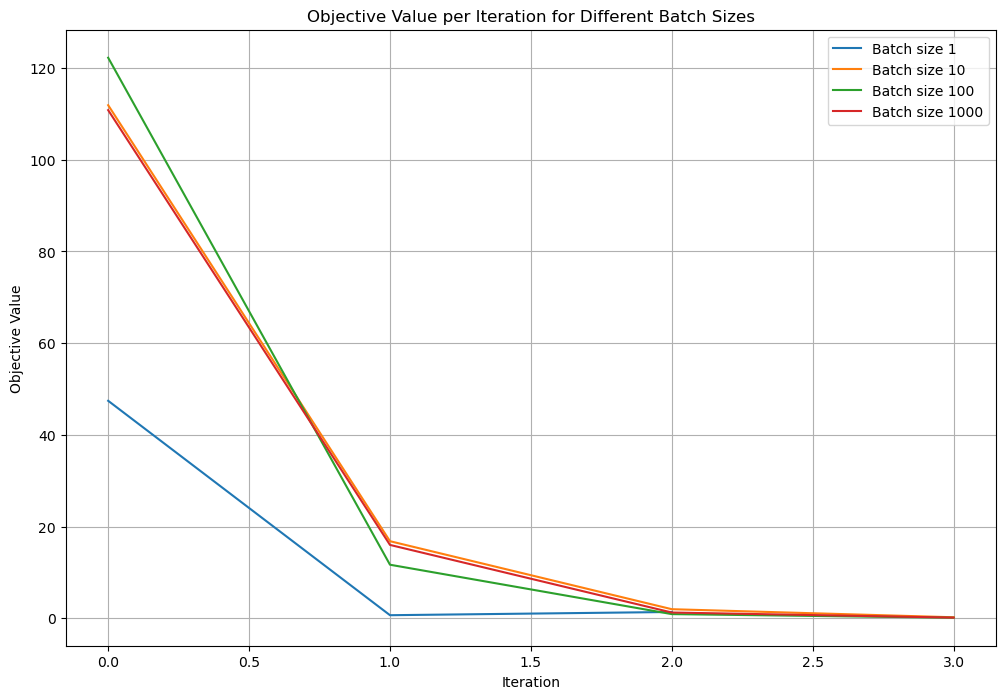

In [8]:
batch_sizes = [1, 10, 100, 1000]
results = {}

for B in batch_sizes:
    _, obj_values = stochastic_gradient_descent(
        x, y, batch_size=B, f=regression_func, epsilon=0.1
    )
    results[B] = obj_values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for B, obj_values in results.items():
    plt.plot(obj_values, label=f'Batch size {B}')

plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Objective Value per Iteration for Different Batch Sizes')
plt.legend()
plt.grid(True)
plt.show()
